# Project 2 - Community detection in an academic network
## Aim
<ol>
  <li> Load social graph</li>
  <li> Run community detection and centrality methods</li>
  <li> Visualize the network </li>
</ol>

## Tasks
<ol>
    <li> <strong>Load the dataset:</strong> Load the Author Network dataset provided in <a href:"https://aminer.org/lab-datasets/soinf/">https://aminer.org/lab-datasets/soinf/</a>
The graph consists of authors and coauthor relationships.
  </li>
    <li> <strong>Implementation:</strong> 
        <ol>
            <li> Implement Girvan-Newman clustering algorithm till 10th iteration level.</li>
            <li> Implement Pagerank algorithm.</li>
            <li> Implement Betweenness centrality measure</li>        
        </ol>
        Use the previous implementation, perform the following tasks
        <ol>
            <li> Use Girvan-Newman algorithm to find clusters of authors</li>
            <li> Find the top-10 authors with highest betweenness centrality</li>      
        </ol>
    </li>
    <li> <strong>Visualization: </strong> 
        <ol>
            <li> Visualize the output of Girvan-Newman algorithm by coloring nodes ccording to their assigned groups</li>
            <li> Visualize the network and highlight the top 10 authors with the highest betweeness centrality and top 10 edges with the highest betweenness centrality</li>      
        </ol>
    </li>


# 1. Load the dataset

In [8]:
# Import Modules
import networkx as nx
from pprint import pprint
import operator
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math

# Utility class to pretty print dictionary
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in iter(self.items()):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(str(len(value))+" "+"graph[s] of size: "+str([len(x) for x in value])+" nodes"))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
print("> All necessary modules imported")

> All necessary modules imported


In [9]:
# Load Data
DATASET = "./data"

def loadData(directoryPath):
    """Load the data of all files of the folder given in parameter."""
    files = os.listdir(directoryPath)
    # dictionary wrt to the following format: {topic1:[[network1],[network2]]}
    allGraphsOfEachTopic = {}
    for file in files:
        topic = ""
        if "T16" in file:
            topic = "Data Mining/Association Rules"
        elif "T107" in file:
            topic = "Web Services"
        elif "T131" in file:
            topic = "Bayesian Networks/Belief function"
        elif "T144" in file:
            topic = "Web Mining/Information Fusion"
        elif "T145" in file:
            topic = "Semantic Web/Description Logics"
        elif "T162" in file:
            topic = "Machine Learning"
        elif "T24" in file:
            topic = "Database Systems/XML Data"
        elif "T75" in file:
            topic = "Information Retrieval"
        else:
            topic = "Unknown"

        graphToBuild = nx.Graph()
        graphToBuild.name = topic.replace('/', ' ').replace(' ', '')

        # constant
        VERTEX = 0
        EDGE = 1
        TRIANGLE = 2

        f = open(DATASET+"/"+file)

        # Vertices: Int "String" Int -> NodeID, personName, #papers
        # Edges: Int Int Int -> sourceNodeID, DestNodeID, #coauthoredPapers
        # Triangles: Int,Int,Int,Int -> NodeID1, NodeID2, NodeID3, #coauthoredPapers
        for line in f:
            if "*Vertices" in line:
                typeOfLine = VERTEX
            elif "*Edges" in line:
                typeOfLine = EDGE
            elif "*Triangles" in line:
                typeOfLine = TRIANGLE
            else:
                if typeOfLine == VERTEX:
                    graph_edge_list = [s.replace(' ','') for s in re.split('"', line)]
                    graphToBuild.add_node(graph_edge_list[0], name=graph_edge_list[1], nbpapers=graph_edge_list[2])
                elif typeOfLine == EDGE:
                    graph_edge_list = line.split()
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapers=graph_edge_list[2])
                elif typeOfLine == TRIANGLE:
                    graph_edge_list = line.split(',')
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[1], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])

        if topic in allGraphsOfEachTopic:
            allGraphsOfEachTopic[topic].append(graphToBuild)
        else:
            allGraphsOfEachTopic[topic] = [graphToBuild]

    return allGraphsOfEachTopic

allData = loadData(DATASET)
print("> All data loaded")
DictTable(allData)


> All data loaded


Web Services,"2 graph[s] of size: [400, 7] nodes"
Bayesian Networks/Belief function,1 graph[s] of size: [554] nodes
Web Mining/Information Fusion,"3 graph[s] of size: [9, 348, 11] nodes"
Semantic Web/Description Logics,"2 graph[s] of size: [671, 10] nodes"
Data Mining/Association Rules,"2 graph[s] of size: [976, 679] nodes"
Database Systems/XML Data,1 graph[s] of size: [1127] nodes
Information Retrieval,"2 graph[s] of size: [657, 7] nodes"


# 2. Implementation
## Implementation of the betweenness centrality measure

In [14]:
def edgesBetweenessCentrality(graph, edge):
    """computes the betweenness centrality of a given edge"""
    centrality = 0
    nodes = list(graph.nodes())
    print(len(nodes))
    counterToRemove=0
    for vi in range(len(nodes) - 1):
        print("vi",vi, "len(node)",len(nodes))
        for vj in range(vi + 1, len(nodes)):

            try:
                shortestPaths = list(nx.all_shortest_paths(graph, source=nodes[vi], target=nodes[vj]))
                nbPathsIncludingEdge = sum(edgeIsInPath([edge[0], edge[1]], path) for path in shortestPaths)
             
                centrality += nbPathsIncludingEdge / len(shortestPaths)
            except nx.NetworkXNoPath:
                continue
    return centrality

def edgeIsInPath(edge, path):
    """checks if an edge is contained in a path of an undirected graph (the path is a list of nodes)"""
    #pathReversed = list(reversed(path))
    #n = len(edge)

    #if edge in (path[i:i + n] for i in range(len(path) + 1 - n)) or edge in (pathReversed[j:j + n] for j in range(len(pathReversed) + 1 - n)):
        #return 1
    #else:
        #return 0
    #Optimized version
    edge1= [edge[0],edge[1]]
    edge2= [edge[1],edge[0]]
    if all(i in path for i in edge1) or all(i in path for i in edge2):
        return 1
    else:
        return 0
    
def nodesBetweennessCentrality(graph, node):
    """betweenness centrality of a given node: not used in this project but implemented for fun"""
    centrality = 0
    nodes = list(graph.nodes())
    for vi in range(len(nodes)-1):
        for vj in range(vi+1, len(nodes)):
            if(nodes[vi] == node or nodes[vj] == node):
                continue

            shortestPaths = list(nx.all_shortest_paths(graph, source=nodes[vi], target=nodes[vj]))
            nbPathsIncludingNode = sum(path.count(node) for path in shortestPaths)
            centrality += nbPathsIncludingNode / len(shortestPaths)
    return centrality

## Implementation of visualizations used in Girvan-Newman clustering (see next cell)

In [15]:
def drawGraph(G):
    """draws the given graph and displays the labels of each edge"""
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos)
    plt.show()

def drawGraphs(G, cnt):
    """Draw all different subgraphs on the same picture"""
    test = plt.subplot(4, 3, cnt)
    if (cnt == 1):
        test.title.set_text('Initial state of the graph')
    else:
        test.title.set_text('State of the graph at iteration: {}, number of communities: {}'.format(cnt-1, nx.number_connected_components(G)))
    test.set_yticklabels([])
    test.set_xticklabels([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos)
    nx.draw_networkx_edge_labels(G, pos)

def drawColoredGraph(G):
    """# draws a graph where communities are drawn using different colors"""
    test = plt.subplot(4,3,12)
    test.set_yticklabels([])
    test.set_xticklabels([])
    test.title.set_text('Resulting communities ({})'.format(nx.number_connected_components(G)))
    pos = nx.spring_layout(G)
    colors = ['red', 'green', 'orange', 'cyan', 'magenta', 'yellow', 'pink', 'white', 'brown', 'wheat']
    connected_components = nx.connected_component_subgraphs(G)
    for index, sg in enumerate(connected_components):
        nx.draw_networkx(sg, pos = pos, edge_color = colors[index], node_color = colors[index])

## Implementation of Girvan-Newman clustering till 10th iteration level

In [ ]:
def girvanNewmanClustering(graph, nbIteration):
    """Implementation of the Girvan-Newman clustering algorithm"""
    edges = list(graph.edges)
    fig = plt.figure(figsize=(50, 50))
    drawGraphs(graph, 1)
    cnt = 2

    if len(edges) == 0:
        return "Empty graph"

    while(len(list(graph.edges)) > 0 and nbIteration > 0):
        print("iteration: ", nbIteration)
        nbIteration = nbIteration - 1
        highestEdge = ""
        highestScore = -float('inf')
        print("iteration: ", nbIteration, "1")
        for edge in edges:
            score = edgesBetweenessCentrality(graph, edge)
            if score > highestScore:
                highestScore = score
                highestEdge = edge
        print("iteration: ", nbIteration, "2")
        graph.remove_edge(highestEdge[0], highestEdge[1])
        drawGraphs(graph, cnt)
        cnt += 1
        print("iteration: ", nbIteration, "3")

    drawColoredGraph(graph)
    print("iteration: ", nbIteration, "4")

    plt.savefig("./Figures/GirvanNewman/{}.png".format(graph.name))
    
    
graph = allData["Information Retrieval"][1]
girvanNewmanClustering(graph, 10)

## Implementation of Girvan-Newman(2, optimized) clustering till 10th iteration level

start
('1', '6')
('1', '2')
('1', '3')
('2', '3')
('4', '6')
('5', '6')
('5', '7')
('1', '2')
('1', '3')
('2', '3')
('4', '6')
('5', '6')
('5', '7')
('1', '2')
('1', '3')
('2', '3')
('4', '6')
('5', '7')
('1', '3')

C:\Users\Jojo\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):



('2', '3')
('4', '6')
('5', '7')
('2', '3')
('4', '6')
('5', '7')
('4', '6')
('5', '7')
('5', '7')


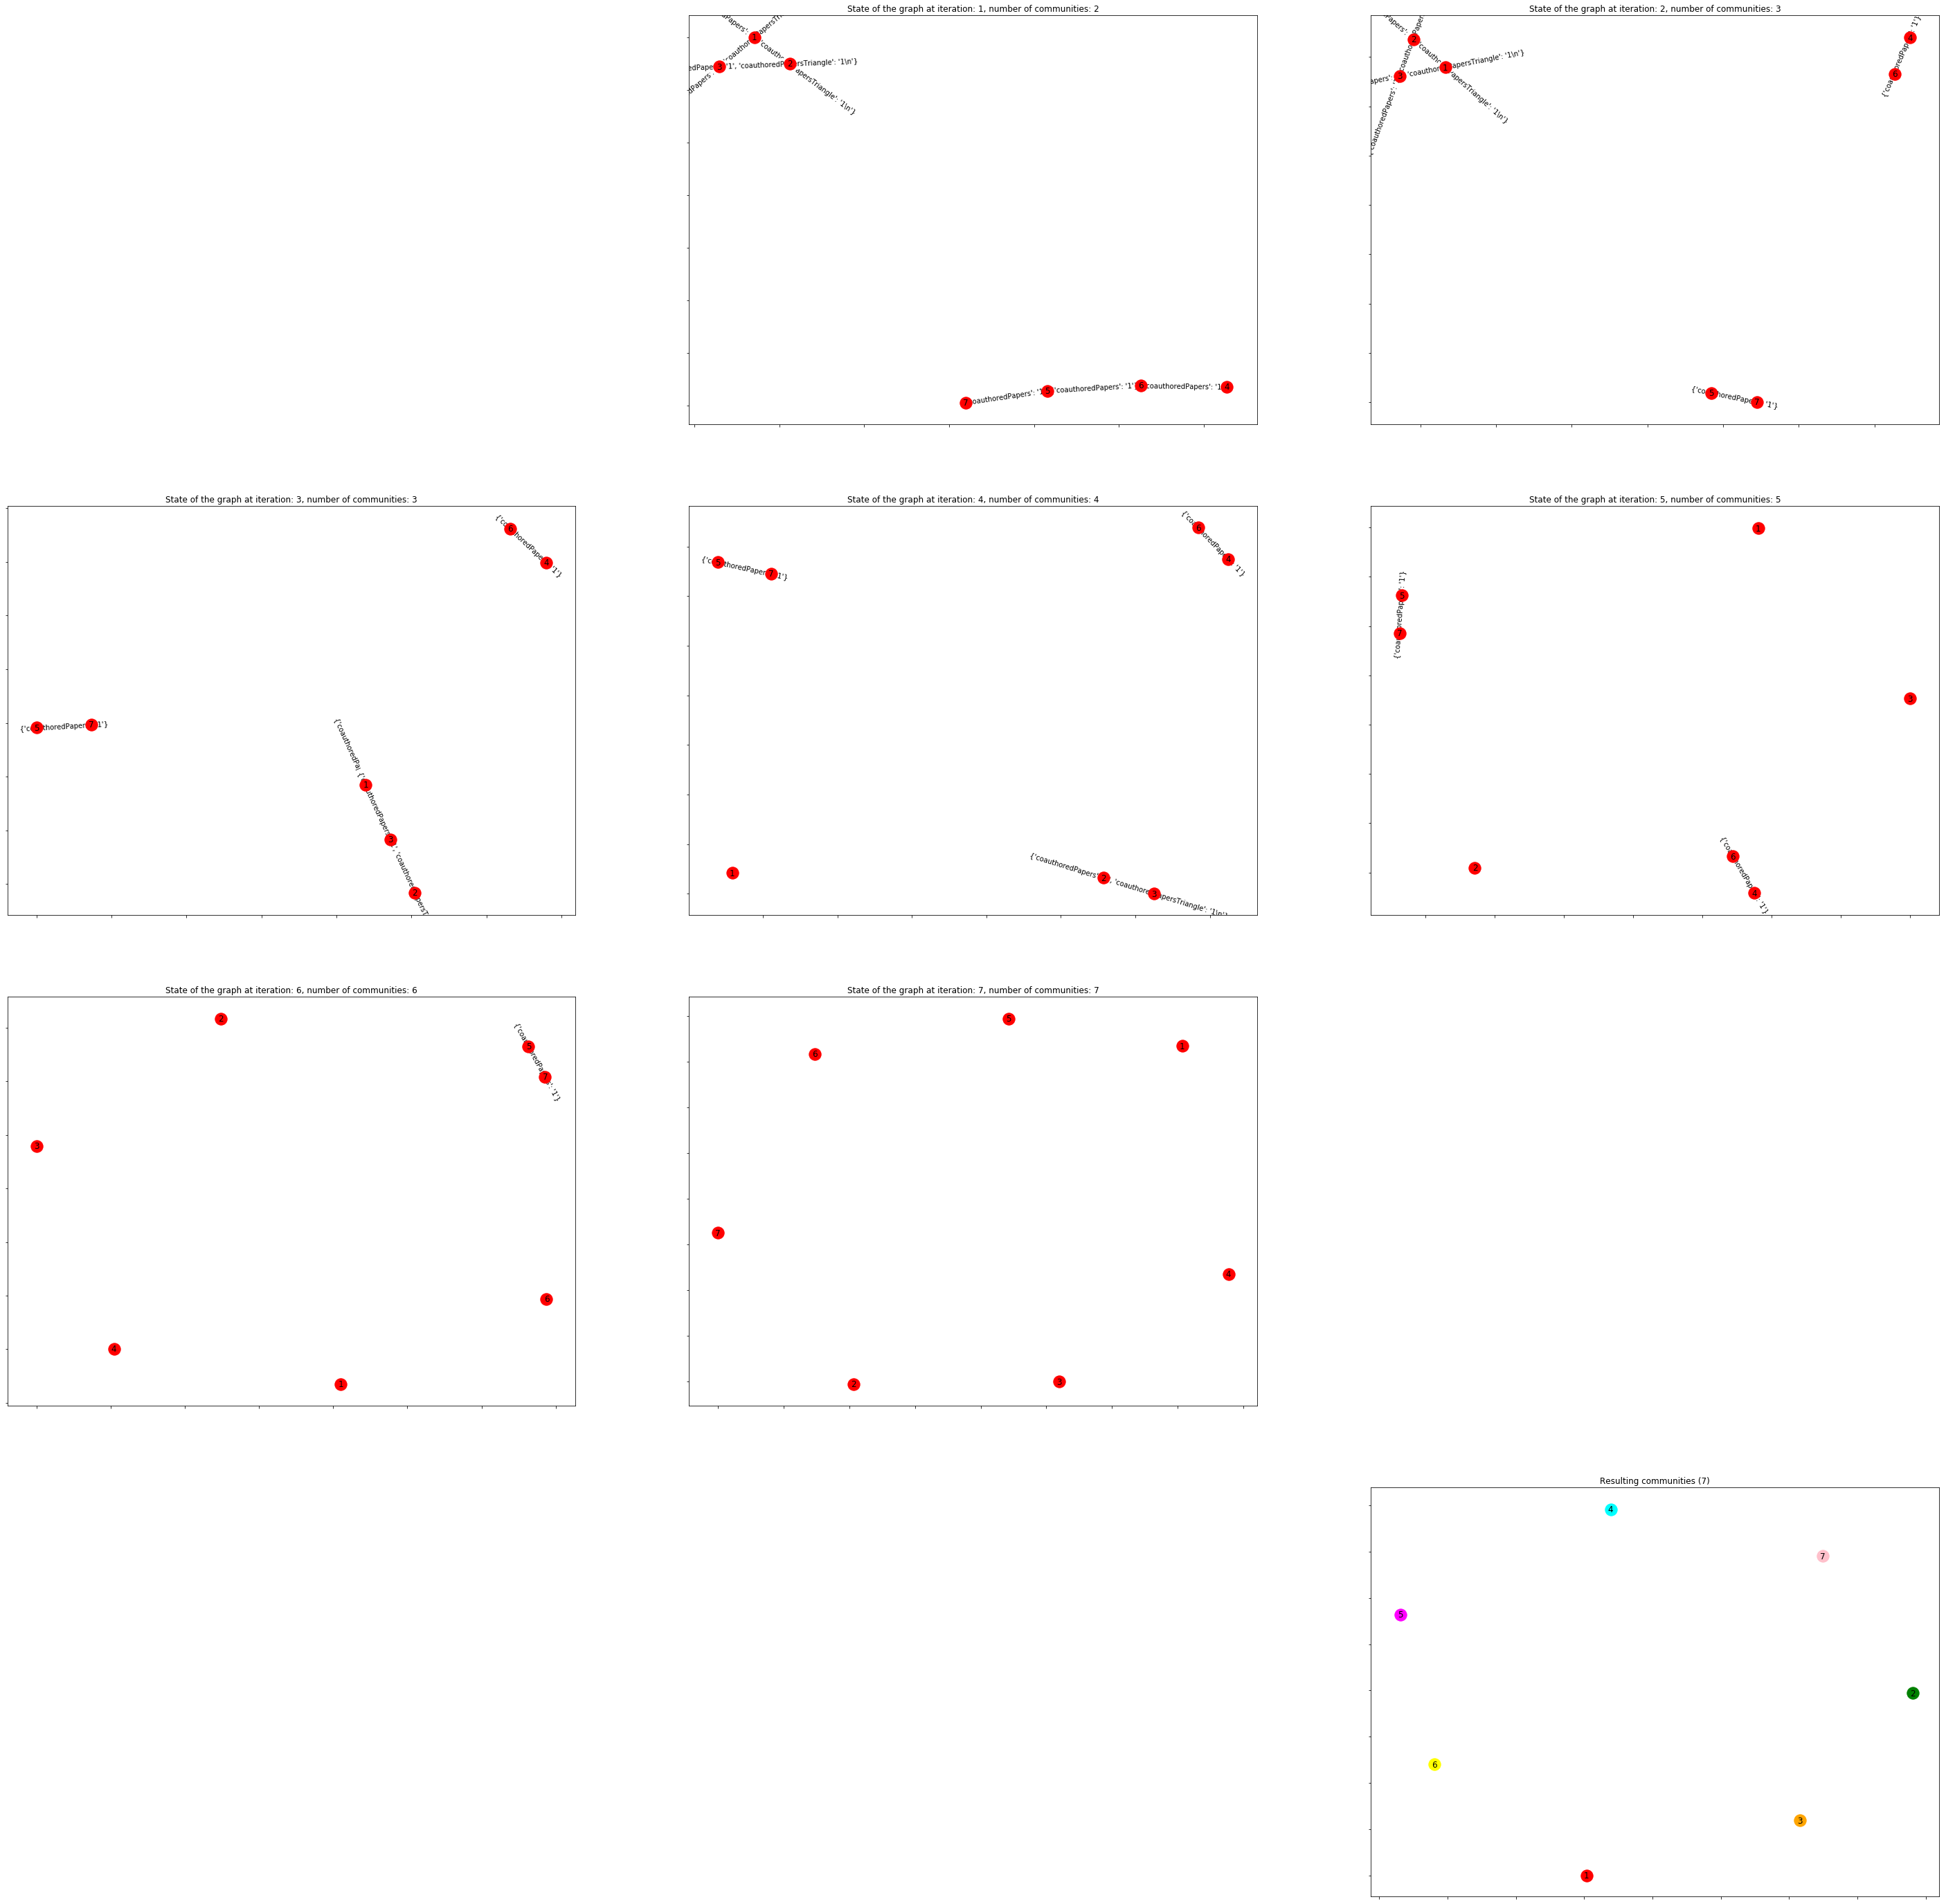

In [16]:
def girvanNewmanClustering(graph, nbIteration):
    
    fig = plt.figure(figsize=(50, 50))
    #drawGraphs(graph, 1)
    cnt = 2

    if len(list(graph.edges)) == 0:
        return "Empty graph"

    print("start")
    while(len(list(graph.edges)) > 0 and nbIteration > 0):
        test = list(nx.all_pairs_shortest_path(graph))
        edges = list(graph.edges)
        highestEdge = ""
        highestScore = -float('inf')
        for edge in graph.edges:
            print(edge)
            centrality=0
            score=0
            nbPathsIncludingEdge=0
            counterShortestPath=0
            for vi in test:
                for vj in vi[1]:
                    nbPathsIncludingEdge += edgeIsInPath([edge[0], edge[1]], vi[1][vj])
                    counterShortestPath+=1
            centrality += nbPathsIncludingEdge / counterShortestPath
            if centrality > highestScore:
                highestScore = centrality
                highestEdge = edge
        graph.remove_edge(highestEdge[0], highestEdge[1])
        drawGraphs(graph, cnt)
        cnt += 1
    drawColoredGraph(graph)       
    plt.savefig("./Figures/GirvanNewman/{}.png".format(graph.name))
                

#graph = allData['Database Systems/XML Data'][0]
graph = allData["Information Retrieval"][1]
#graph = allData["Data Mining/Association Rules"][0]
girvanNewmanClustering(graph, 10)

## Implementation of Pagerank algorithm

In [11]:
def pageRankCentrality(graph, alpha, beta):
    # Transposition of matrix
    adjacencyMatrix = nx.to_numpy_matrix(graph, weight='None')
    amTransposed = np.transpose(adjacencyMatrix)

    # Diagonal Matrix
    diagonalMatrix = np.zeros([adjacencyMatrix.shape[0], adjacencyMatrix.shape[1]])
    row, col = np.diag_indices(diagonalMatrix.shape[0])
    # Compute the values that have to be filled into the diagonal
    diagonalMatrix[row, col] = [1 / degree[1] for degree in list(graph.degree())]

    # Identity matrix
    identityMatrix = np.identity(adjacencyMatrix.shape[0])

    # Vector of ones
    ones = np.ones((adjacencyMatrix.shape[0], 1))
    pageRankCentrality = np.dot(beta * np.linalg.inv((identityMatrix - np.dot(alpha * amTransposed, diagonalMatrix))), ones)

    return pageRankCentrality

